#### 5) Results

As we have discussed, during the course of the training procedure the results of all trained agents in "test_mode" are written out and stored, as well as the results from the best agent at each error rate. However, in order to ease computational time during training, each agent was only benchmarked for 100 episodes. In this notebook we present these raw preliminary results from the training procedure, as well as provide a script for obtaining more rigorous results from the optimal trained models.

##### 5a) Preliminary Results

Here we present the preliminary results, as obtained from within the training procedure, and from which the controller script based its decisions.

In [1]:
import numpy as np
import keras
import tensorflow
import gym

from Function_Library import *
from Environments import *

import rl as rl
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy, GreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger

import json
import copy
import sys
import os
import shutil
import datetime

from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
directory_dict = {"X Noise": os.path.join(os.getcwd(),"../results/d5_x/"),
                  "DP Noise": os.path.join(os.getcwd(),"../results/d5_dp/")}

results_dict = {}
for key in directory_dict.keys():
    results_list = []
    for file in os.listdir(directory_dict[key]):
        if "best" in file:
            with open(directory_dict[key]+file) as f:
                content = f.readlines()
            content = [x.strip() for x in content]
            start_index = content[0].index(":")
            result = float(content[0][start_index+2:])
            results_list.append(result)
    results_list.sort(reverse=True)
    results_dict[key] = results_list
    
    

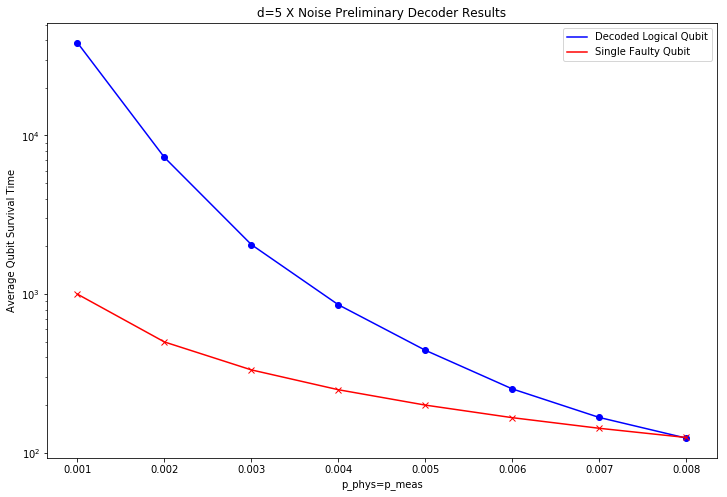

In [3]:
end = 8
p_phys = [j/1000 for j in range(1, end+1)]
bench = [1/p for p in p_phys]
key = "X Noise"

_=plt.figure(figsize=[12,8])
plt.semilogy(p_phys[:end],results_dict[key][:end],"b",label="Decoded Logical Qubit")
plt.semilogy(p_phys[:end],results_dict[key][:end],"bo")
plt.semilogy(p_phys[:end],bench[:end],"r",label="Single Faulty Qubit")
plt.semilogy(p_phys[:end],bench[:end],"rx")
plt.title("d=5 X Noise Preliminary Decoder Results")
plt.xlabel("p_phys=p_meas")
plt.ylabel("Average Qubit Survival Time")
_=plt.legend()

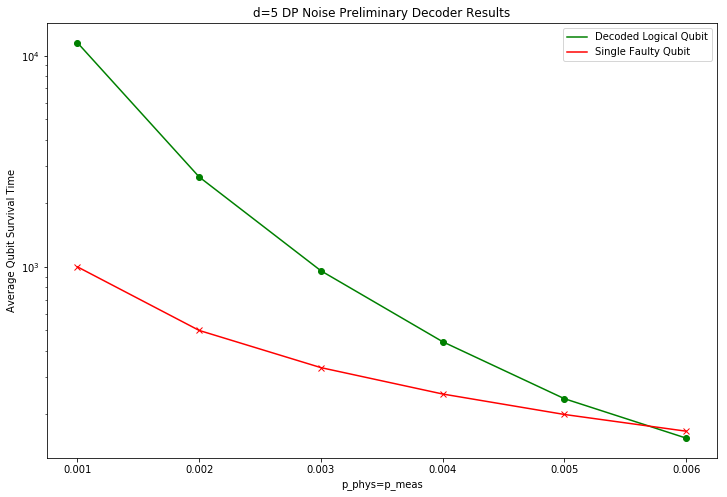

In [4]:
end = 6
p_phys = [j/1000 for j in range(1, end+1)]
bench = [1/p for p in p_phys]
key = "DP Noise"

_=plt.figure(figsize=[12,8])
plt.semilogy(p_phys[:end],results_dict[key][:end],"g",label="Decoded Logical Qubit")
plt.semilogy(p_phys[:end],results_dict[key][:end],"go")
plt.semilogy(p_phys[:end],bench[:end],"r",label="Single Faulty Qubit")
plt.semilogy(p_phys[:end],bench[:end],"rx")
plt.title("d=5 DP Noise Preliminary Decoder Results")
plt.xlabel("p_phys=p_meas")
plt.ylabel("Average Qubit Survival Time")
_=plt.legend()

##### 5b) Rigorous Results - !NB: TO DO! Run these cells for many episodes!

As mentioned, the preliminary results above were obtained directly from the training procedure over only 100 episodes. As such we would like to obtain more rigorous results over more benchmarking episodes, which can be done with the following methodology.

We begin by defining a function for evaluation of a single point, which we can then loop over:

In [28]:
def evaluate_single_point(models_directory, error_rate, nb_testing_episodes, static_decoder):
    
    # Load all the configs
    fixed_configs_path = os.path.join(models_directory,"fixed_config.p")
    
    error_rate_directory = os.path.join(models_directory,error_rate+"/")
    all_files = os.listdir(os.path.join(error_rate_directory))
    
    for file in all_files:
        if "config" in file:
            variable_configs_path = os.path.join(error_rate_directory, file)
    
    model_weights_path = os.path.join(error_rate_directory,"dqn_weights.h5f")

    fixed_configs = pickle.load( open(fixed_configs_path, "rb" ) )
    variable_configs = pickle.load( open(variable_configs_path, "rb" ) )

    all_configs = {}

    for key in fixed_configs.keys():
        all_configs[key] = fixed_configs[key]

    for key in variable_configs.keys():
        all_configs[key] = variable_configs[key]
        
    # instantiate the environment
    env = Surface_Code_Environment_Multi_Decoding_Cycles(d=all_configs["d"], 
    p_phys=all_configs["p_phys"], 
    p_meas=all_configs["p_meas"],  
    error_model=all_configs["error_model"], 
    use_Y=all_configs["use_Y"], 
    volume_depth=all_configs["volume_depth"],
    static_decoder=static_decoder)
    
    # Instantiate the agent
    model = build_convolutional_nn(all_configs["c_layers"],all_configs["ff_layers"], env.observation_space.shape, env.num_actions)
    memory = SequentialMemory(limit=all_configs["buffer_size"], window_length=1)
    policy = GreedyQPolicy(masked_greedy=True)
    test_policy = GreedyQPolicy(masked_greedy=True)

    dqn = DQNAgent(model=model, 
                   nb_actions=env.num_actions, 
                   memory=memory, 
                   nb_steps_warmup=all_configs["learning_starts"], 
                   target_model_update=all_configs["target_network_update_freq"], 
                   policy=policy,
                   test_policy=test_policy,
                   gamma = all_configs["gamma"],
                   enable_dueling_network=all_configs["dueling"])  


    dqn.compile(Adam(lr=all_configs["learning_rate"]))
    
    # Load the weights
    dqn.model.load_weights(model_weights_path)
    
    # Test
    nb_test_episodes = nb_testing_episodes
    testing_history = dqn.test(env,nb_episodes = nb_test_episodes, visualize=False, 
                               verbose=2, interval=100, single_cycle=False)
    
    return testing_history.history["episode_lifetime"]

And now we can perform the required evaluations:

#### NB: This needs to be done properly! This was just a test of the code with only two evaluations per point!

In [30]:
nb_testing_episodes = 2

models_directory = os.path.join(os.getcwd(),"../trained_models/d5_x/")
static_decoder_path = os.path.join(os.getcwd(),"referee_decoders/nn_d5_X_p5")
static_decoder = load_model(static_decoder_path)

error_rates = ["0.001", "0.002", "0.003", "0.004", "0.005", "0.006", "0.007", "0.008"]

final_all_results = {}
final_mean_results = {}
for error_rate in error_rates:
    print("Evaluating at error rate:" ,error_rate)
    print()
    
    final_all_results[error_rate] = evaluate_single_point(models_directory,error_rate,nb_testing_episodes, static_decoder)
    final_mean_results[error_rate] = np.mean(final_all_results[error_rate])

Evaluating at error rate: 0.001

Testing for 2 episodes ...
-----------------
Episode: 1
This Episode Length: 3409
This Episode Reward: 3128.0
This Episode Lifetime: 46695

Episode Lifetimes Avg: 46695.000

Evaluating at error rate: 0.002

Testing for 2 episodes ...
-----------------
Episode: 1
This Episode Length: 1560
This Episode Reward: 1357.0
This Episode Lifetime: 11725

Episode Lifetimes Avg: 11725.000

Evaluating at error rate: 0.003

Testing for 2 episodes ...
-----------------
Episode: 1
This Episode Length: 171
This Episode Reward: 132.0
This Episode Lifetime: 885

Episode Lifetimes Avg: 885.000

Evaluating at error rate: 0.004

Testing for 2 episodes ...
-----------------
Episode: 1
This Episode Length: 9
This Episode Reward: 0.0
This Episode Lifetime: 30

Episode Lifetimes Avg: 30.000

Evaluating at error rate: 0.005

Testing for 2 episodes ...
-----------------
Episode: 1
This Episode Length: 136
This Episode Reward: 95.0
This Episode Lifetime: 465

Episode Lifetimes Avg:

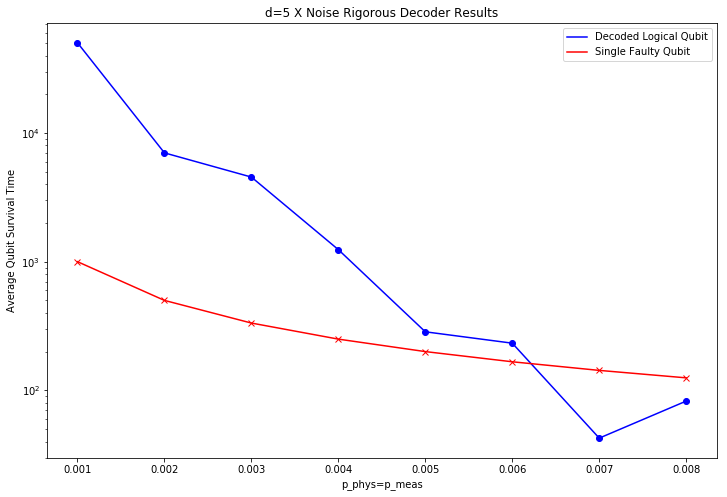

In [36]:
final_results = [final_mean_results[key] for key in error_rates]

end = 8
p_phys = [j/1000 for j in range(1, end+1)]
bench = [1/p for p in p_phys]
key = "X Noise"

_=plt.figure(figsize=[12,8])
plt.semilogy(p_phys[:end],final_results[:end],"b",label="Decoded Logical Qubit")
plt.semilogy(p_phys[:end],final_results[:end],"bo")
plt.semilogy(p_phys[:end],bench[:end],"r",label="Single Faulty Qubit")
plt.semilogy(p_phys[:end],bench[:end],"rx")
plt.title("d=5 X Noise Rigorous Decoder Results")
plt.xlabel("p_phys=p_meas")
plt.ylabel("Average Qubit Survival Time")
_=plt.legend()